In [2]:
import numpy as np 
from matplotlib import pyplot as plt
import pandas as pd
import json

In [3]:
S_U = 10
S_R = 10/5
V_REF = 3.3
BIT_ADC = 10
T = 60 * 6
FS = 9400 #Hz
N = FS * T
test_sections = [("high",0,60*2), ("mid", 60*2,60*4), ("low",60*4,60*6)]
data_paths = ["random-indoor","random-indoor-cafe","light-indoor","light-indoor-cafe","change-indoor","change-indoor-cafe"]
voltages = [2.8,2.7,2.6,2.5,2.4,2.3,2.2,2.1,2.0,1.9,1.8,1.7,1.6,1.5,1.4]
names = ["baseline","random", "random-cafe","light","light-cafe","change","change-cafe"]
names_b = ["random", "random-cafe","light","light-cafe","change","change-cafe"]
baseline_power = 118.272012 / 1000
baseline_std = 45.454833
#voltages.reverse()
data_frames = [] 
data_frames_split = []
times = []

def calc_derived_value(data_frame):
    delta_voltage_analog = np.abs(data_frame[" value ch1"] - data_frame[" value ch0"])
    current_analog = delta_voltage_analog / S_U
    power_analog = current_analog * data_frame[" value ch2"]
    
    delta_digital_voltage = np.abs(data_frame[" value ch4"] - data_frame[" value ch3"])
    current_digital = delta_digital_voltage / S_R
    power_digital = current_digital * data_frame[" value ch2"] 
    
    delta_control_voltage = np.abs(data_frame[" value ch5"] - data_frame[" value ch6"])
    power_control = (delta_control_voltage/ S_R) * V_REF
    
    data_frame["power_analog"] = power_analog
    data_frame["power_digital"] = power_digital
    data_frame["power_total"] = power_analog + power_digital
    data_frame["power_control"] = power_control 
    
    return(data_frame)

for path in data_paths: 
    df = pd.read_csv( f"./data/{path}.csv",skiprows=1)
    keys_values = list(filter(lambda x : "value" in x, df.keys()))
    keys_samples = list(filter(lambda x : "sample" in x, df.keys()))
    df[keys_values] = (df[keys_values] / (2**BIT_ADC))*V_REF
    df = calc_derived_value(df)
    entry = {}
    for n,s,f in test_sections:
        start = df[df.isin([int(s*FS)]).any(axis=1)].index.values[0]
        finish = df[df.isin([int(f*FS)]).any(axis=1)].index.values[0]
        print(n,start,finish)
        entry[n] = df[start:finish]
    data_frames_split.append(entry)
    
    row_max = df[df.isin([int(N)]).any(axis=1)].index.values[0]
    df = df[:row_max]
    data_frames.append(df)
    f = open(f"./data/{path}.json",)
    times.append(json.load(f))
    f.close()
    


high 0 161142
mid 161142 322285
low 322285 483428
high 0 161142
mid 161142 322285
low 322285 483428
high 0 161142
mid 161142 322285
low 322285 483428
high 0 161142
mid 161142 322285
low 322285 483428
high 0 161142
mid 161142 322285
low 322285 483428
high 0 161142
mid 161142 322285
low 322285 483428


In [4]:
data_frames_split[1].keys()

dict_keys(['high', 'mid', 'low'])

light-cafe
random


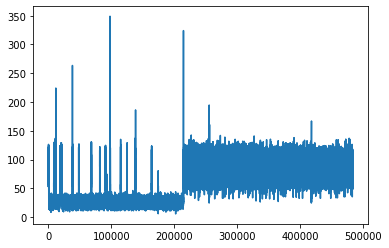

In [5]:
#Voltage vs Time Charts
i=3
j = 0 
r = "high"
print(names_b[i])
print(names_b[j])
plt.plot((data_frames[i]["power_total"] *1000))
#plt.plot((data_frames_split[j][r]["power_total"][0:1000]))

In [7]:
average_power = []
energy = []
std_power = []
average_analog = []
average_digital = [] 
for df in data_frames: 
    std_power.append((df["power_total"]*1000).std())
    average_power.append(df["power_total"].mean())
    average_analog.append(df["power_analog"].mean())
    average_digital.append(df["power_digital"].mean())
    energy.append((np.array(df["power_total"]) * 1/FS).sum())
    
average_power_split = {"high":[],
                       "mid" :[],
                       "low" :[]} 
for df in data_frames_split:
    average_power_split["high"].append(df["high"]["power_digital"].mean())
    average_power_split["mid"].append(df["mid"]["power_digital"].mean())
    average_power_split["low"].append(df["low"]["power_digital"].mean())

average_power_split["high"] = np.array([baseline_power] + average_power_split["high"])
average_power_split["mid"] = np.array([baseline_power] + average_power_split["mid"])
average_power_split["low"] = np.array([baseline_power] + average_power_split["low"])

average_power = np.array([baseline_power] + average_power)
average_analog = np.array(average_analog)
average_digital = np.array(average_digital)

    

In [8]:
energy

[2.2790021609578157,
 2.2922286226999944,
 2.36792787822398,
 2.0719079362042336,
 1.4554857575207512,
 1.3083853671674461]

ValueError: shape mismatch: objects cannot be broadcast to a single shape

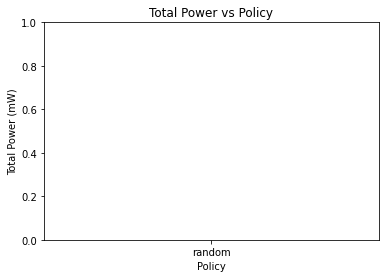

In [9]:
plt.title("Total Power vs Policy")
plt.xlabel("Policy")
plt.ylabel("Total Power (mW)")
names_b = ["random", "random-cafe","light","light-cafe","change","change-cafe"]
plt.bar(names_b,energy*1000, label='Total Power')
#plt.bar(names,average_digital*1000, label='Digital Power')
#plt.bar(names,average_analog*1000, label='Analog Power')
plt.legend()
#plt.figsave("test.png")

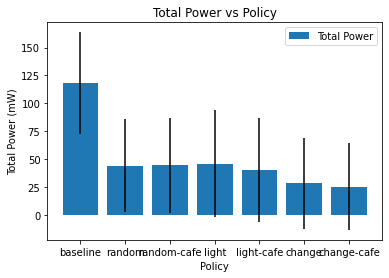

In [16]:
plt.title("Total Power vs Policy")
plt.xlabel("Policy")
plt.ylabel("Total Power (mW)")
plt.bar(names,average_power*1000,yerr=[baseline_std]+std_power, label='Total Power')
#plt.bar(names,average_digital*1000, label='Digital Power')
#plt.bar(names,average_analog*1000, label='Analog Power')
plt.legend()
#plt.figsave("test.png")

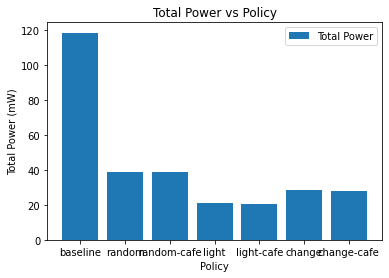

In [150]:
plt.title("Total Power vs Policy")
plt.xlabel("Policy")
plt.ylabel("Total Power (mW)")
plt.bar(names,average_power_split["high"]*1000, label='Total Power')
#plt.bar(names,average_digital*1000, label='Digital Power')
#plt.bar(names,average_analog*1000, label='Analog Power')
plt.legend()
#plt.figsave("test.png")

change


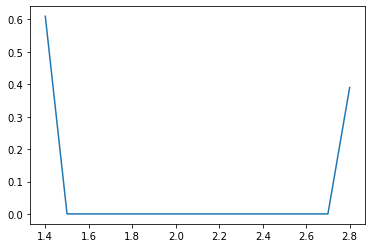

In [100]:
i = 4
print(names[i])
freq = np.array([times[i][str(volt)] for volt in voltages])
freq_n = freq / freq.sum()
plt.plot(voltages,freq_n)

In [73]:
(6*60)*9453

3403080

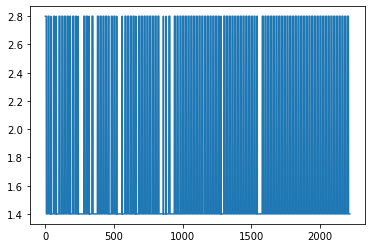

In [14]:
plt.plot(times[5]['series'])

In [12]:
len(times)

6